In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_shape = (28, 28, 1)
z_dim = 100

In [3]:
#def build_generator(img_shape, z_dim):
def build_generator(img_shape):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    #model.add(Flatten(input_shape=img_shape))
    #model.add(Dense(128))    
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
#generator = build_generator(img_shape, z_dim)
# 왜 없지?
generator = build_generator(img_shape)
optimizer_g = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def train_step(z, real):
    with tf.GradientTape() as tape:
        gen_imgs = generator(z)
        pred = discriminator(gen_imgs)
        loss = tf.keras.losses.binary_crossentropy(real, pred) #? real or fake?

    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients, generator.trainable_variables))

    train_loss(loss)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train / 127.5 - 1.0 # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    import time
    start = time.time()  # 시작 시간 저장    
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        #z = np.random.normal(0, 1, (batch_size, 28*28))
        # ? 생성자 훈련 먼저하기?
        #z = z.reshape(batch_size, 28, 28, 1)
        #g_loss = generator.train_on_batch(z, imgs)
        
        #gen_imgs = generator.predict(z)
        
        # 생성자 훈련?
        gen_imgs, g_loss = train_step(z, real)
        
        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        #z = np.random.normal(0, 1, (batch_size, 100))
        #gen_imgs = generator.predict(z)

        # 생성자 훈련
        #g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" % (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)
    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5
    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D 손실: 0.029514, 정확도: 100.00%] [G 손실: 4.769324]
time : 16.657787561416626
2000 [D 손실: 0.068738, 정확도: 97.27%] [G 손실: 4.587822]
time : 41.370270013809204
3000 [D 손실: 0.086360, 정확도: 97.27%] [G 손실: 4.735651]
time : 58.29620718955994
4000 [D 손실: 0.243004, 정확도: 91.41%] [G 손실: 4.803257]
time : 83.99961996078491
5000 [D 손실: 0.113169, 정확도: 95.70%] [G 손실: 4.804076]
time : 108.37689733505249
6000 [D 손실: 0.625766, 정확도: 77.34%] [G 손실: 4.704746]
time : 126.62875890731812
7000 [D 손실: 0.218549, 정확도: 91.80%] [G 손실: 4.578373]
time : 143.84018468856812
8000 [D 손실: 0.265375, 정확도: 89.84%] [G 손실: 4.464247]
time : 160.37551760673523
9000 [D 손실: 0.397710, 정확도: 82.81%] [G 손실: 4.353948]
time : 177.12550163269043
10000 [D 손실: 0.332043, 정확도: 85.55%] [G 손실: 4.253632]
time : 196.02666187286377
11000 [D 손실: 0.309536, 정확도: 88.28%] [G 손실: 4.176034]
time : 215.87905836105347
12000 [D 손실: 0.323091, 정확도: 86.72%] [G 손실: 4.110075]
time : 234.85193967819214
13000 [D 손실: 0.401802, 정확도: 83.59%] [G 손실: 4.046361]
time : 25

<ipython-input-8-0af46f71a502>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4, 4), sharey=True, sharex=True)


22000 [D 손실: 0.321153, 정확도: 87.11%] [G 손실: 3.660666]
time : 421.5778033733368
23000 [D 손실: 0.353263, 정확도: 83.98%] [G 손실: 3.625461]
time : 439.4936423301697
24000 [D 손실: 0.390905, 정확도: 82.81%] [G 손실: 3.592741]
time : 457.3491265773773
25000 [D 손실: 0.408281, 정확도: 84.38%] [G 손실: 3.560891]
time : 477.2437541484833
26000 [D 손실: 0.570002, 정확도: 74.22%] [G 손실: 3.527632]
time : 495.41706705093384
27000 [D 손실: 0.281406, 정확도: 87.50%] [G 손실: 3.496733]
time : 514.0474760532379
28000 [D 손실: 0.365747, 정확도: 83.20%] [G 손실: 3.464357]
time : 532.0201938152313
29000 [D 손실: 0.423458, 정확도: 82.81%] [G 손실: 3.432848]
time : 551.3149733543396
30000 [D 손실: 0.328726, 정확도: 84.77%] [G 손실: 3.402603]
time : 569.5639092922211


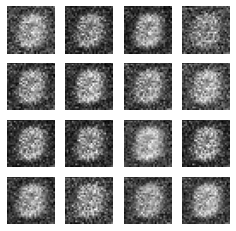

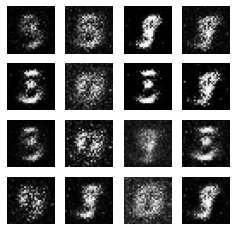

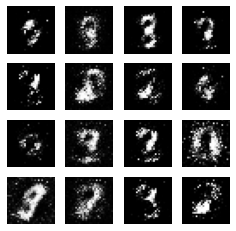

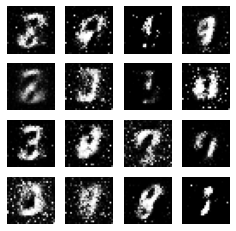

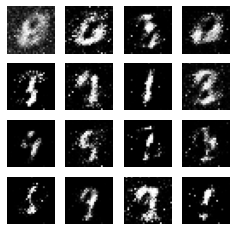

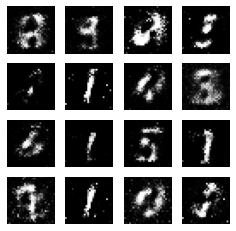

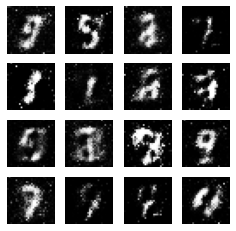

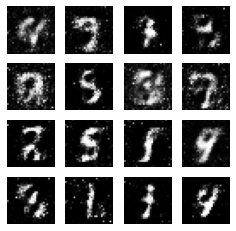

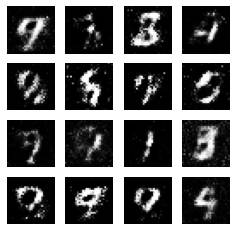

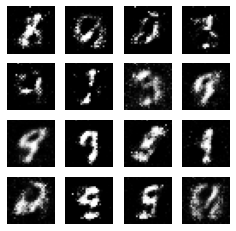

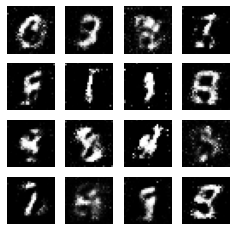

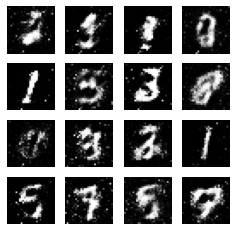

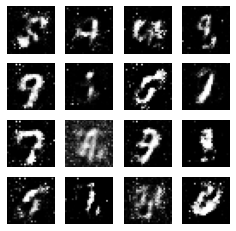

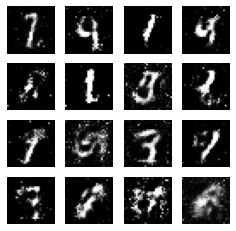

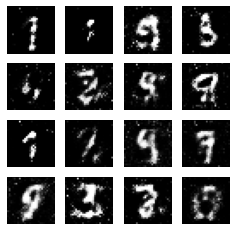

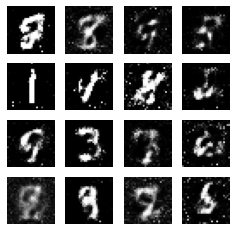

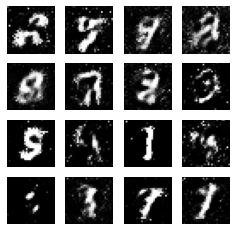

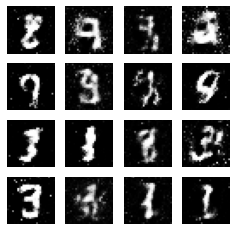

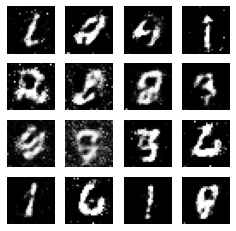

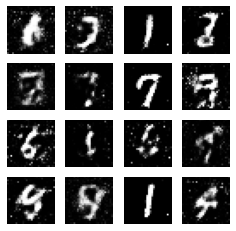

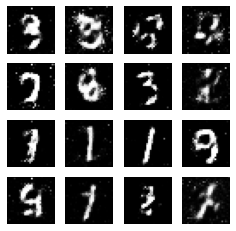

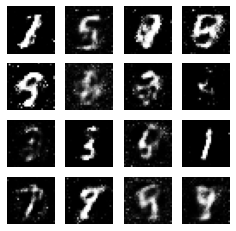

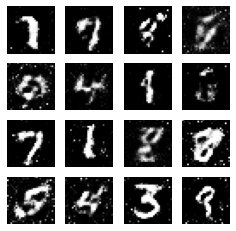

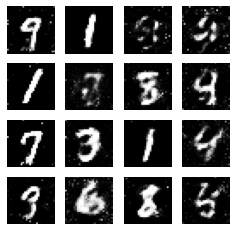

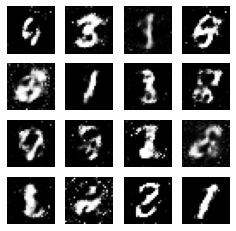

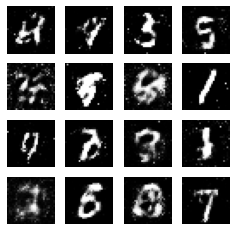

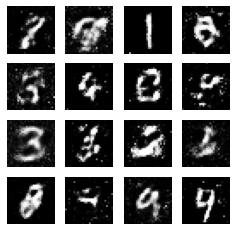

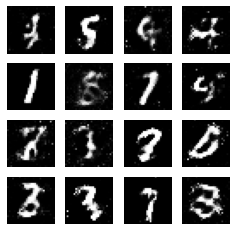

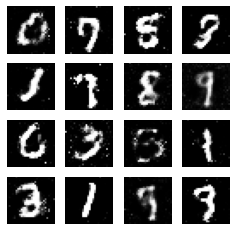

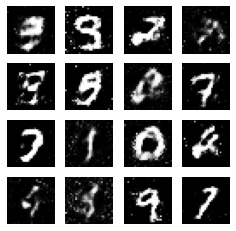

In [9]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

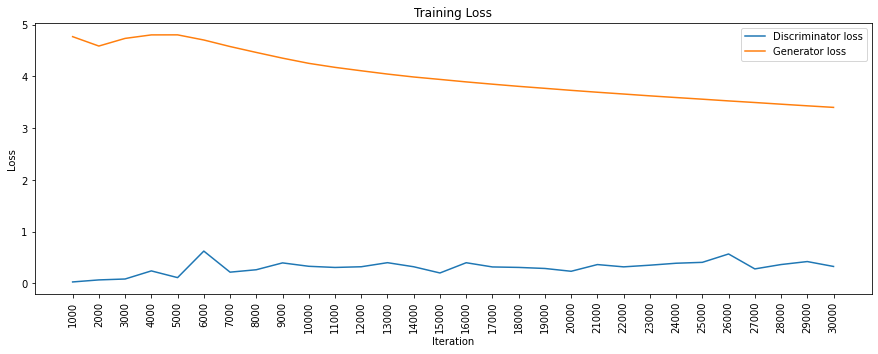

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

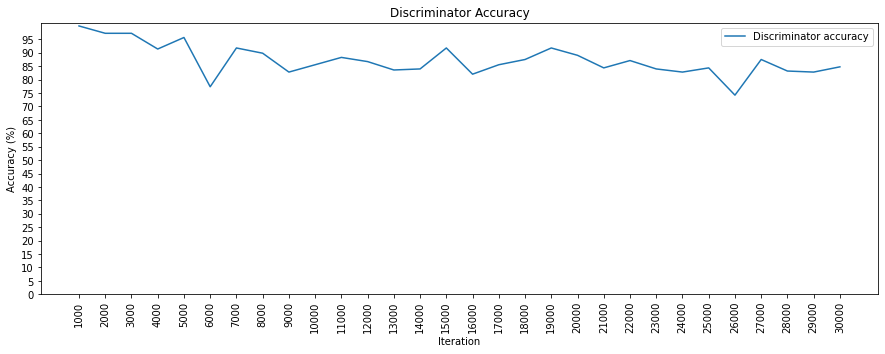

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()